In [19]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/banglamct7-bangla-multiclass-text-dataset-7-tags/BanglaMCT7/train.csv
/kaggle/input/banglamct7-bangla-multiclass-text-dataset-7-tags/BanglaMCT7/test.csv
/kaggle/input/bangla-stopwords/stopwords_bangla.xlsx


# **Updating/Instaling Libraries**

In [20]:
!pip install keras
!pip install --upgrade tensorflow
!pip install --upgrade tensorflow-gpu
!pip install xlrd==1.2.0
!pip install openpyxl

In [21]:
import pandas as pd
from pandas import read_excel
import numpy as np
import re
from re import sub
import multiprocessing
from unidecode import unidecode
import os
from time import time 


from sklearn import metrics
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import LSTM,Dense,Dropout,Activation,Embedding,Flatten,Bidirectional,MaxPooling2D, Conv1D, MaxPooling1D
from tensorflow.python.keras.models import Sequential

from keras.layers import MaxPool1D

from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras import regularizers

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical


import h5py
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report 


from nltk.corpus import stopwords
import nltk
import re
from nltk.stem import WordNetLemmatizer
import string
from nltk.tokenize import word_tokenize
from nltk.util import ngrams

# **Loading Dataset**

In [22]:
df_train=pd.read_csv("/kaggle/input/banglamct7-bangla-multiclass-text-dataset-7-tags/BanglaMCT7/train.csv")
df_test=pd.read_csv("/kaggle/input/banglamct7-bangla-multiclass-text-dataset-7-tags/BanglaMCT7/test.csv")


In [23]:

df_train['count'] = df_train['cleanText'].str.split().str.len()
df_test['count'] = df_test['cleanText'].str.split().str.len()
display(df_train)
df_train.head()
df_train.describe()
df_train.info()
print(df_train.category.unique())

,category,text,cleanText,count
0,economy,বাংলাদেশে সফররত বিশ্ব বাণিজ্য সংস্থা (ডব্লিউট...,বাংলাদেশে সফররত বিশ্ব বাণিজ্য সং...,293
1,sports,ইউরোপিয়ান ফুটবলে আজ ঝড় বয়ে যাচ্ছে। একদিকে সংবা...,ইউরোপিয়ান ফুটবলে বয়ে একদিকে সংবা...,206
2,international,বিজেপির নেতৃত্বে ভারতের উত্তর প্রদেশ থেকে শুরু...,বিজেপির নেতৃত্বে ভারতের উত্তর প্...,167
3,state,নারায়ণগঞ্জের সোনারগাঁ উপজেলার একটি সরকারি প্র...,নারায়ণগঞ্জের সোনারগাঁ উপজেলার সরকা...,181
4,sports,"‘ছাই থেকে ছাই, ধুলো থেকে ধুলো...’ আধ্যাত্মিক ক...",ছাই ছাই ধুলো ধুলো আধ্যাত্মিক ...,148
...,...,...,...,...
98878,education,সহকারী অধ্যাপক টিচার্স ট্রেনিং কলেজ (মহিলা)...,সহকারী অধ্যাপক টিচার্স ট্রেনিং ক...,389
98879,entertainment,অক্টোবরের ১১ তারিখে ৭৫ বছর পূর্ণ করবেন অমিতাভ ...,অক্টোবরের তারিখে বছর পূর্ণ অমিতা...,147
98880,technology,কাজী নাঈম আল রশিদ। সফটওয়্যার প্রকৌশলী। কাজ করে...,কাজী নাঈম রশিদ সফটওয়্যার প্রকৌশল...,673
98881,technology,ইয়াহুকে মার্কিন টেলিকম প্রতিষ্ঠান ভেরাইজন কিনে...,ইয়াহুকে মার্কিন টেলিকম প্রতিষ্ঠান ...,161


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98883 entries, 0 to 98882
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   category   98883 non-null  object
 1   text       98883 non-null  object
 2   cleanText  98883 non-null  object
 3   count      98883 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 3.0+ MB
['economy' 'sports' 'international' 'state' 'technology' 'entertainment'
 'education']


In [24]:
display(df_test)
df_test.head()
df_test.describe()
df_test.info()

,category,text,cleanText,count
0,education,"অধ্যায়-২প্রিয় পরীক্ষার্থী, আজ তথ্য ও যোগাযোগ প...",অধ্যায় প্রিয় পরীক্ষার্থী তথ্য যো...,260
1,sports,"স্পিন, স্পিন, স্পিন। লর্ডসে ইয়াসির শাহ্‌র লেগ ...",স্পিন স্পিন স্পিন লর্ডসে ইয়াসির ...,131
2,international,সিরিয়ার উত্তর-পশ্চিমাঞ্চলে গতকাল রোববার বিমান...,সিরিয়ার উত্তর পশ্চিমাঞ্চলে গতকাল ...,75
3,international,দক্ষিণ আফ্রিকার কেপটাউন বিশ্ববিদ্যালয়ের (ইউসিট...,দক্ষিণ আফ্রিকার কেপটাউন বিশ্ববিদ্যা...,49
4,technology,সহজে ডিজিটাল আর্থিক সেবা দিতে অ্যাপ ও ডিজিটাল ...,সহজে ডিজিটাল আর্থিক সেবা অ্যাপ ...,172
...,...,...,...,...
98879,sports,১৯৫৯ সালে ইউরোপিয়ান ক্লাব কাপে জাতীয় দল পাঠান...,সালে ইউরোপিয়ান ক্লাব কাপে জাতীয়...,14
98880,entertainment,গানের দল সহজিয়ার প্রথম অ্যালবাম ‘রঙমিস্ত্রী’র ...,গানের সহজিয়ার প্রথম অ্যালবাম রঙম...,163
98881,international,ফেসবুকের ৮১ হাজার ব্যবহারকারীর তথ্য চুরি করে স...,ফেসবুকের হাজার ব্যবহারকারীর তথ্য ...,159
98882,economy,পেট্রোল পাম্পে তেল বা সিএনজির বিল বিকাশের মাধ...,পেট্রোল পাম্পে তেল সিএনজির বিল ...,14


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98884 entries, 0 to 98883
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   category   98884 non-null  object
 1   text       98884 non-null  object
 2   cleanText  98884 non-null  object
 3   count      98884 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 3.0+ MB


In [25]:
def stopwordRemoval(text):    
    x=str(text)
    l=x.split()

    stm=[elem for elem in l if elem not in stop]
    
    out=' '.join(stm)
    
    return str(out)

# **Stopwords Removal**

In [26]:
data1 =pd.read_excel('/kaggle/input/bangla-stopwords/stopwords_bangla.xlsx')
display(data1)
stop = data1['words'].tolist()

,Unnamed: 0,words
0,0,অই
1,1,অগত্যা
2,2,অত: পর
3,3,অতএব
4,4,অথচ
...,...,...
727,727,হয়েই
728,728,হয়েছিল
729,729,হয়েছে
730,730,হয়েছেন


In [27]:
#df_train['cleanText'] = df_train.cleanText.apply(lambda x: stopwordRemoval(str(x)))


In [28]:
#df_test['cleanText'] = df_test.cleanText.apply(lambda x: stopwordRemoval(str(x)))

# **Stemming**

In [29]:
#make sure to turn on internet on your kernel
#importing stemmer
!pip install bangla-stemmer
from bangla_stemmer.stemmer import stemmer
## stemmer function
def stem_text (x):
  stmr = stemmer.BanglaStemmer()
  words=x.split(' ')
  stm = stmr.stem(words)
  words=(' ').join(stm)
  return words

In [30]:
#df_train['cleanText']=df_train['cleanText'].apply(stem_text)
#df_test['cleanText']=df_test['cleanText'].apply(stem_text)

# **Changing Labels to Numbers**

In [31]:
#['economy' 'sports' 'international' 'state' 'technology' 'entertainment' 'education']

df_train["category"].replace({"economy": "0", "sports": "1","international": "2","state": "3","technology": "4","entertainment": "5","education": "6"}, inplace=True)
df_test["category"].replace({"economy": "0", "sports": "1","international": "2","state": "3","technology": "4","entertainment": "5","education": "6"}, inplace=True)
display(df_train)
display(df_test)

,category,text,cleanText,count
0,0,বাংলাদেশে সফররত বিশ্ব বাণিজ্য সংস্থা (ডব্লিউট...,বাংলাদেশে সফররত বিশ্ব বাণিজ্য সং...,293
1,1,ইউরোপিয়ান ফুটবলে আজ ঝড় বয়ে যাচ্ছে। একদিকে সংবা...,ইউরোপিয়ান ফুটবলে বয়ে একদিকে সংবা...,206
2,2,বিজেপির নেতৃত্বে ভারতের উত্তর প্রদেশ থেকে শুরু...,বিজেপির নেতৃত্বে ভারতের উত্তর প্...,167
3,3,নারায়ণগঞ্জের সোনারগাঁ উপজেলার একটি সরকারি প্র...,নারায়ণগঞ্জের সোনারগাঁ উপজেলার সরকা...,181
4,1,"‘ছাই থেকে ছাই, ধুলো থেকে ধুলো...’ আধ্যাত্মিক ক...",ছাই ছাই ধুলো ধুলো আধ্যাত্মিক ...,148
...,...,...,...,...
98878,6,সহকারী অধ্যাপক টিচার্স ট্রেনিং কলেজ (মহিলা)...,সহকারী অধ্যাপক টিচার্স ট্রেনিং ক...,389
98879,5,অক্টোবরের ১১ তারিখে ৭৫ বছর পূর্ণ করবেন অমিতাভ ...,অক্টোবরের তারিখে বছর পূর্ণ অমিতা...,147
98880,4,কাজী নাঈম আল রশিদ। সফটওয়্যার প্রকৌশলী। কাজ করে...,কাজী নাঈম রশিদ সফটওয়্যার প্রকৌশল...,673
98881,4,ইয়াহুকে মার্কিন টেলিকম প্রতিষ্ঠান ভেরাইজন কিনে...,ইয়াহুকে মার্কিন টেলিকম প্রতিষ্ঠান ...,161


,category,text,cleanText,count
0,6,"অধ্যায়-২প্রিয় পরীক্ষার্থী, আজ তথ্য ও যোগাযোগ প...",অধ্যায় প্রিয় পরীক্ষার্থী তথ্য যো...,260
1,1,"স্পিন, স্পিন, স্পিন। লর্ডসে ইয়াসির শাহ্‌র লেগ ...",স্পিন স্পিন স্পিন লর্ডসে ইয়াসির ...,131
2,2,সিরিয়ার উত্তর-পশ্চিমাঞ্চলে গতকাল রোববার বিমান...,সিরিয়ার উত্তর পশ্চিমাঞ্চলে গতকাল ...,75
3,2,দক্ষিণ আফ্রিকার কেপটাউন বিশ্ববিদ্যালয়ের (ইউসিট...,দক্ষিণ আফ্রিকার কেপটাউন বিশ্ববিদ্যা...,49
4,4,সহজে ডিজিটাল আর্থিক সেবা দিতে অ্যাপ ও ডিজিটাল ...,সহজে ডিজিটাল আর্থিক সেবা অ্যাপ ...,172
...,...,...,...,...
98879,1,১৯৫৯ সালে ইউরোপিয়ান ক্লাব কাপে জাতীয় দল পাঠান...,সালে ইউরোপিয়ান ক্লাব কাপে জাতীয়...,14
98880,5,গানের দল সহজিয়ার প্রথম অ্যালবাম ‘রঙমিস্ত্রী’র ...,গানের সহজিয়ার প্রথম অ্যালবাম রঙম...,163
98881,2,ফেসবুকের ৮১ হাজার ব্যবহারকারীর তথ্য চুরি করে স...,ফেসবুকের হাজার ব্যবহারকারীর তথ্য ...,159
98882,0,পেট্রোল পাম্পে তেল বা সিএনজির বিল বিকাশের মাধ...,পেট্রোল পাম্পে তেল সিএনজির বিল ...,14


# **Removing Null values**

In [32]:
#display non-null values
df_train = df_train.dropna()
df_test = df_test.dropna()

# **Removing Small Texts**

In [33]:
#counting text length
df_train['count'] = df_train['cleanText'].str.split().str.len()
df_test['count'] = df_test['cleanText'].str.split().str.len()
# Remove the text with words less than 5
df_train= df_train.loc[df_train['count']>5]
df_test= df_test.loc[df_test['count']>5]

# **Removing Duplicate Rows**

In [34]:
df_train.drop_duplicates()
df_test.drop_duplicates()

,category,text,cleanText,count
0,6,"অধ্যায়-২প্রিয় পরীক্ষার্থী, আজ তথ্য ও যোগাযোগ প...",অধ্যায় প্রিয় পরীক্ষার্থী তথ্য যো...,260
1,1,"স্পিন, স্পিন, স্পিন। লর্ডসে ইয়াসির শাহ্‌র লেগ ...",স্পিন স্পিন স্পিন লর্ডসে ইয়াসির ...,131
2,2,সিরিয়ার উত্তর-পশ্চিমাঞ্চলে গতকাল রোববার বিমান...,সিরিয়ার উত্তর পশ্চিমাঞ্চলে গতকাল ...,75
3,2,দক্ষিণ আফ্রিকার কেপটাউন বিশ্ববিদ্যালয়ের (ইউসিট...,দক্ষিণ আফ্রিকার কেপটাউন বিশ্ববিদ্যা...,49
4,4,সহজে ডিজিটাল আর্থিক সেবা দিতে অ্যাপ ও ডিজিটাল ...,সহজে ডিজিটাল আর্থিক সেবা অ্যাপ ...,172
...,...,...,...,...
98879,1,১৯৫৯ সালে ইউরোপিয়ান ক্লাব কাপে জাতীয় দল পাঠান...,সালে ইউরোপিয়ান ক্লাব কাপে জাতীয়...,14
98880,5,গানের দল সহজিয়ার প্রথম অ্যালবাম ‘রঙমিস্ত্রী’র ...,গানের সহজিয়ার প্রথম অ্যালবাম রঙম...,163
98881,2,ফেসবুকের ৮১ হাজার ব্যবহারকারীর তথ্য চুরি করে স...,ফেসবুকের হাজার ব্যবহারকারীর তথ্য ...,159
98882,0,পেট্রোল পাম্পে তেল বা সিএনজির বিল বিকাশের মাধ...,পেট্রোল পাম্পে তেল সিএনজির বিল ...,14


# **Shuffle Dataset**

In [35]:
df_train = df_train.sample(frac=1).reset_index(drop=True)
display(df_train)
display(df_test)

,category,text,cleanText,count
0,5,বিয়ের ব্যাপারটি প্রকাশ্যে আসার পর এবার ছিল জনপ...,বিয়ের ব্যাপারটি প্রকাশ্যে আসার জ...,99
1,3,ক্ষমতাসীন আওয়ামী লীগের ভ্রাতৃপ্রতিম সংগঠন বাংল...,ক্ষমতাসীন আওয়ামী লীগের ভ্রাতৃপ্রতিম...,150
2,5,বয়সভিত্তিক নাচ প্রতিযোগিতার আয়োজন করেছিল নৃত...,বয়সভিত্তিক নাচ প্রতিযোগিতার আয়োজন...,60
3,1,পুরো দেশ অস্থির। হবে না-ই বা কেন। দুটি ম্যাচ ...,পুরো দেশ অস্থির ম্যাচ দক্ষিণ ...,151
4,4,নকিয়া ৮ বাজারে আসতে না আসতেই ইতিমধ্যে গুঞ্জন ...,নকিয়া বাজারে আসতে আসতেই ইতিমধ্যে...,96
...,...,...,...,...
98620,1,হোয়াইট হার্ট লেনে পরশু টটেনহামের গ্যালারিতে কি...,হোয়াইট হার্ট লেনে পরশু টটেনহামের...,442
98621,1,‘শৃঙ্খলা-ভঙ্গের’ অভিযোগে বোলার আল আমিন হোসেনের...,শৃঙ্খলা ভঙ্গের অভিযোগে বোলার আমি...,186
98622,2,বন্ধুরাষ্ট্রের প্রতি সামান্য অবিশ্বাস দেখানোও ...,বন্ধুরাষ্ট্রের সামান্য অবিশ্বাস দেখ...,51
98623,1,পেনাল্টির আবেদন করেছিলেন। রেফারি বাঁশিও বাজিয়ে...,পেনাল্টির আবেদন রেফারি বাঁশিও বা...,107


,category,text,cleanText,count
0,6,"অধ্যায়-২প্রিয় পরীক্ষার্থী, আজ তথ্য ও যোগাযোগ প...",অধ্যায় প্রিয় পরীক্ষার্থী তথ্য যো...,260
1,1,"স্পিন, স্পিন, স্পিন। লর্ডসে ইয়াসির শাহ্‌র লেগ ...",স্পিন স্পিন স্পিন লর্ডসে ইয়াসির ...,131
2,2,সিরিয়ার উত্তর-পশ্চিমাঞ্চলে গতকাল রোববার বিমান...,সিরিয়ার উত্তর পশ্চিমাঞ্চলে গতকাল ...,75
3,2,দক্ষিণ আফ্রিকার কেপটাউন বিশ্ববিদ্যালয়ের (ইউসিট...,দক্ষিণ আফ্রিকার কেপটাউন বিশ্ববিদ্যা...,49
4,4,সহজে ডিজিটাল আর্থিক সেবা দিতে অ্যাপ ও ডিজিটাল ...,সহজে ডিজিটাল আর্থিক সেবা অ্যাপ ...,172
...,...,...,...,...
98879,1,১৯৫৯ সালে ইউরোপিয়ান ক্লাব কাপে জাতীয় দল পাঠান...,সালে ইউরোপিয়ান ক্লাব কাপে জাতীয়...,14
98880,5,গানের দল সহজিয়ার প্রথম অ্যালবাম ‘রঙমিস্ত্রী’র ...,গানের সহজিয়ার প্রথম অ্যালবাম রঙম...,163
98881,2,ফেসবুকের ৮১ হাজার ব্যবহারকারীর তথ্য চুরি করে স...,ফেসবুকের হাজার ব্যবহারকারীর তথ্য ...,159
98882,0,পেট্রোল পাম্পে তেল বা সিএনজির বিল বিকাশের মাধ...,পেট্রোল পাম্পে তেল সিএনজির বিল ...,14


In [36]:
train_sentences=df_train['cleanText'].values
train_labels=df_train['category'].values

In [37]:
test_sentences=df_test['cleanText'].values
test_labels=df_test['category'].values

In [38]:
print("Training Set Length: "+str(len(df_train)))
print("Testing Set Length: "+str(len(df_test)))
print("train_labels shape: "+str(train_labels.shape))
print("test_labels shape: "+str(test_labels.shape))

Training Set Length: 98625
Testing Set Length: 98602
train_labels shape: (98625,)
test_labels shape: (98602,)


# **Train/Test/Validation Set**
**This dataset contains two csv files. One is Train set and another is Test set.IN EDA,we have seen that train and test set is equal sized and distribution of class is identical to both of the test and train set.
I have used full train set for training and used 20% of the data from testset for validation set and 80% for testing
The validation set and the Test set is partitioned into stratified fashion to keep the distribution of class intact.**

In [39]:
test_sentences, validation_sentences,test_labels, validation_labels = train_test_split(test_sentences, test_labels,stratify=test_labels,test_size=0.2)

In [40]:
train_labels=keras.utils.to_categorical(train_labels)
test_labels=keras.utils.to_categorical(test_labels)
validation_labels=keras.utils.to_categorical(validation_labels)


print("Training Set Length: "+str(len(df_train)))
print("Testing Set Length: "+str(len(df_test)))
print("training_sentences shape: "+str(train_sentences.shape))
print("testing_sentences shape: "+str(test_sentences.shape))
print("validation_sentences shape: "+str(validation_sentences.shape))
print("train_labels shape: "+str(train_labels.shape))
print("test_labels shape: "+str(test_labels.shape))
print("validation_labels shape: "+str(validation_labels.shape))

Training Set Length: 98625
Testing Set Length: 98602
training_sentences shape: (98625,)
testing_sentences shape: (78881,)
validation_sentences shape: (19721,)
train_labels shape: (98625, 7)
test_labels shape: (78881, 7)
validation_labels shape: (19721, 7)


In [41]:
print(train_sentences[1])
print(train_labels[0])

  ক্ষমতাসীন    আওয়ামী    লীগের    ভ্রাতৃপ্রতিম    সংগঠন    বাংলাদেশ    ছাত্রলীগের    দুই    কর্মীকে    সিলেটের    জালালাবাদে    কুপিয়ে    জখমের    বাংলাদেশ    ইসলামী    ছাত্রশিবিরকে    দায়ী    ছাত্রলীগের    সভাপতি    সাইফুর    রহমান    ছাত্রশিবিরের    ওপর    পাল্টা    আক্রমণের    ঘোষণা    হামলার    প্রতিবাদে    বুধবার    ঢাকা    বিশ্ববিদ্যালয়ের    ছাত্র    শিক্ষক    কেন্দ্রের    টিএসসি    রাজু    ভাস্কর্যের    সামনে    সমাবেশে    সাইফুর    রহমান    ঘোষণা    ডিফেনসিভে    থাকলে    চলবে    অ্যাটাকিংয়ে    স্ট্রাইকারের    ভূমিকায়    স্লোগান    মিছিল    সমাবেশ    শিবিরকে    প্রতিহত    অ্যাটাকিংয়ে    ছাত্রলীগের    কর্মীদের    আপনারা    খুঁজুন    শিবির    কোথায়    প্রতিহত    করুন    রাজশাহী    বিশ্ববিদ্যালয়    লক্ষ্মীপুরে    শিবিরকে    প্রতিহত    শুরু    উল্লেখ    ছাত্রলীগের    সভাপতি    শোকের    মাসে    শোককে    শক্তিতে    পরিণত    জামায়াত    শিবিরকে    শক্ত    হাতে    দমন    জেলা    উপজেলা    পাড়া    মহল্লা    ইউনিয়নের    কোথাও    জামায়াত    শিবির    থাকতে    পারবে    খুঁজে    খুঁজে    দমন  

# **Tokenization**

In [42]:
vocab_size = 100000
embedding_dim = 150
max_length = 600
trunc_type='post'
oov_tok = "<OOV>"

print(train_sentences.shape)
print(train_labels.shape)


tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

#464246 words in raw dataset
#463651 words in raw dataset after stopwords removal
#***** after stemming 

print(len(word_index))
print("Word index length:"+str(len(tokenizer.word_index)))
sequences = tokenizer.texts_to_sequences(train_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)


test_sequences = tokenizer.texts_to_sequences(test_sentences)
testing_padded = pad_sequences(test_sequences,maxlen=max_length)

validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences,maxlen=max_length)

(98625,)
(98625, 7)
464230
Word index length:464230


# **After Tokenization Data visualization**

In [43]:
print("Sentence :--> \n")
print(train_sentences[2]+"\n")
print("Sentence Tokenized and Converted into Sequence :--> \n")
print(str(sequences[2])+"\n")
print("After Padding the Sequence with padding length 100 :--> \n")
print(padded[2])

Sentence :--> 

  বয়সভিত্তিক    নাচ    প্রতিযোগিতার    আয়োজন    করেছিল    নৃত্যশিল্পী    সংস্থা    শিল্পকলা    একাডেমী    গতকাল    বৃহস্পতিবার    সন্ধ্যায়    শিল্পকলা    একাডেমীর    সংগীত    নৃত্যকলাকেন্দ্র    মিলনায়তনে    অনুষ্ঠিত    প্রতিযোগিতার    সমাপনী    অনুষ্ঠান    সারা    দেশের    নাচের    দলকে    পুরস্কার    পাশাপাশি    প্রতিটি    সেরা    ক্যাটাগরিতে    পুরস্কার    মোট    প্রতিযোগীকে    শিল্পকলা    একাডেমীর    মহাপরিচালক    লিয়াকত    আলীর    সভাপতিত্বে    সমাপনী    আয়োজনে    প্রধান    অতিথি    সংস্কৃতিমন্ত্রী    আসাদুজ্জামান    নূর    অনুষ্ঠানে    স্বাগত    বক্তব্য    নৃত্যশিল্পী    সংস্থার    সভাপতি    মিনু    শুভেচ্ছা    বক্তব্য    সংস্থার    সাধারণ    সম্পাদক    মাহফুজুর    রহমান  

Sentence Tokenized and Converted into Sequence :--> 

[8624, 2704, 9440, 1725, 514, 7067, 254, 1417, 6180, 16, 125, 835, 1417, 4808, 727, 1, 1225, 111, 9440, 2350, 340, 301, 19, 4418, 782, 218, 88, 315, 151, 4266, 218, 2351, 1, 1417, 4808, 1720, 5715, 2200, 1036, 2350, 6617, 27, 397, 6875,

In [44]:
print("Padded shape(training): "+str(padded.shape))
print("Padded shape(testing): "+str(testing_padded.shape))

Padded shape(training): (98625, 600)
Padded shape(testing): (78881, 600)


# **Model Creation**

In [45]:
from tensorflow.python.keras.optimizer_v2.adam import Adam
model= Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(Conv1D(150, kernel_size=3, activation = "relu"))
model.add(MaxPool1D(pool_size=16))
model.add(Bidirectional(LSTM(16, return_sequences=True)))
#l2 regularizer
model.add(Dense(10,kernel_regularizer=regularizers.l2(0.01),activation="relu"))
model.add(Flatten())
model.add(Dense(7, activation='softmax'))
#sgd= SGD(lr=0.0001,decay=1e-6,momentum=0.9,nesterov=True)
adam=Adam(learning_rate=0.00005,beta_1=0.9,beta_2=0.999,epsilon=1e-07,amsgrad=False)
model.summary()
model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])

2021-10-20 04:48:24.233563: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-20 04:48:24.301065: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/cuda/compat
2021-10-20 04:48:24.315627: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1835] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 600, 150)          15000000  
_________________________________________________________________
conv1d (Conv1D)              (None, 598, 150)          67650     
_________________________________________________________________
module_wrapper (ModuleWrappe (None, 37, 150)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 37, 32)            21376     
_________________________________________________________________
dense (Dense)                (None, 37, 10)            330       
_________________________________________________________________
flatten (Flatten)            (None, 370)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 2

In [46]:
history=model.fit(padded,train_labels,epochs=10,batch_size=256,validation_data=( validation_padded,validation_labels),use_multiprocessing=True, workers=8)

2021-10-20 04:48:24.894564: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 236700000 exceeds 10% of free system memory.
2021-10-20 04:48:25.115806: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
386/386 [==============================] - 640s 2s/step - loss: 2.0560 - accuracy: 0.2692 - val_loss: 1.8943 - val_accuracy: 0.3688
Epoch 2/10
386/386 [==============================] - 624s 2s/step - loss: 1.1932 - accuracy: 0.6874 - val_loss: 0.6801 - val_accuracy: 0.8602
Epoch 3/10
386/386 [==============================] - 625s 2s/step - loss: 0.5373 - accuracy: 0.8933 - val_loss: 0.5194 - val_accuracy: 0.8894
Epoch 4/10
386/386 [==============================] - 627s 2s/step - loss: 0.4010 - accuracy: 0.9266 - val_loss: 0.4740 - val_accuracy: 0.8991
Epoch 5/10
386/386 [==============================] - 615s 2s/step - loss: 0.3274 - accuracy: 0.9461 - val_loss: 0.4593 - val_accuracy: 0.9040
Epoch 6/10
386/386 [==============================] - 609s 2s/step - loss: 0.2764 - accuracy: 0.9589 - val_loss: 0.4461 - val_accuracy: 0.9064
Epoch 7/10
386/386 [==============================] - 602s 2s/step - loss: 0.2364 - accuracy: 0.9685 - val_loss: 0.4551 - val_accuracy: 0.9055

# **Learning Curve**

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


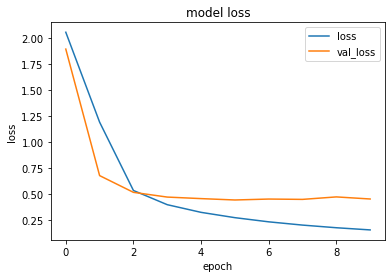

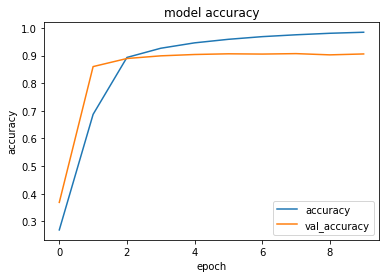

In [47]:
print(history.history.keys())
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'])
plt.show()

accuracy = history.history['accuracy']
val_accuracy= history.history['val_accuracy']
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()


# **Evaluation**

In [48]:
#accuracy calculation
loss_and_metrics = model.evaluate(padded,train_labels,batch_size=256)
print("The train accuracy is: "+str(loss_and_metrics[1]))
loss_and_metrics = model.evaluate(testing_padded,test_labels,batch_size=256)
print("The test accuracy is: "+str(loss_and_metrics[1]))

2021-10-20 06:31:52.710116: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 236700000 exceeds 10% of free system memory.


386/386 [==============================] - 134s 347ms/step - loss: 0.1471 - accuracy: 0.9865
The train accuracy is: 0.9865247011184692


2021-10-20 06:34:06.734696: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 189314400 exceeds 10% of free system memory.


309/309 [==============================] - 106s 342ms/step - loss: 0.4548 - accuracy: 0.9061
The test accuracy is: 0.9061371088027954


In [49]:
predictions = model.predict(testing_padded)

2021-10-20 06:35:52.523306: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 189314400 exceeds 10% of free system memory.


In [50]:
predictions = np.argmax(predictions, axis=-1) 

In [51]:
test_labels=np.argmax(test_labels, axis=-1)

In [52]:
precision, recall, fscore, _ = precision_recall_fscore_support(test_labels,predictions, average='weighted')
print("Precision :"+str(precision))
print("Recall :"+str(recall))
print("fscore :"+str(fscore))

Precision :0.9067235401713108
Recall :0.9061370925824976
fscore :0.9060858303839899


# **Confusion Matrix & Classification Report**

,precision,recall,f1-score,support
economy,88.27,89.33,88.80,11584.000000
sports,97.84,96.33,97.08,12693.000000
international,93.20,90.44,91.80,12250.000000
state,89.73,84.26,86.91,12146.000000
technology,83.24,84.01,83.62,7948.000000
entertainment,91.78,94.75,93.24,12194.000000
education,86.98,92.97,89.87,10066.000000
accuracy,90.61,90.61,90.61,0.906137
macro avg,90.15,90.30,90.19,78881.000000
weighted avg,90.67,90.61,90.61,78881.000000


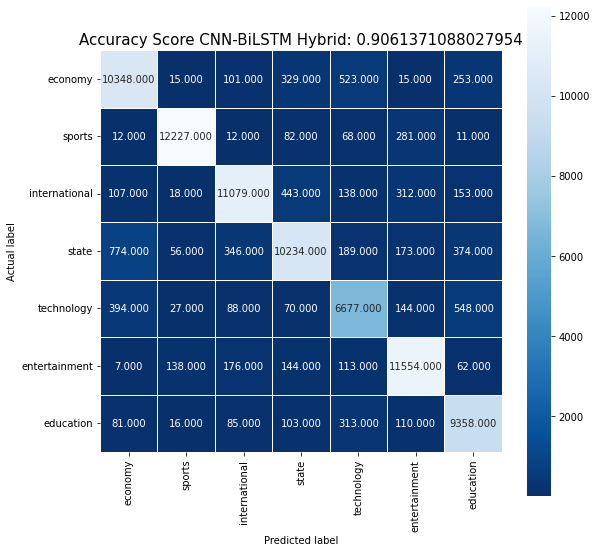

In [53]:
#['economy' 'sports' 'international' 'state' 'technology' 'entertainment' 'education']

cm = metrics.confusion_matrix(test_labels,predictions)
# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,index = ['economy' ,'sports' ,'international', 'state','technology', 'entertainment', 'education'], 
                     columns = ['economy' ,'sports' ,'international', 'state','technology', 'entertainment', 'education'])

plt.figure(figsize=(9,9))
sns.heatmap(cm_df, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score CNN-BiLSTM Hybrid: {0}'.format(loss_and_metrics[1])
plt.title(all_sample_title, size = 15);

report = pd.DataFrame(classification_report(y_true = test_labels, y_pred = predictions, output_dict=True)).transpose()
report = report.rename(index={'0': 'economy','1':'sports','2':'international','3':'state','4':'technology','5':'entertainment','6':'education'})
report[['precision','recall','f1-score']]=report[['precision','recall','f1-score']].apply(lambda x: round(x*100,2))
display(report)